# Python for Data Science Project Session 3: Mathematics and Statistics

In this project session, we will look at three mini-topics related to Mathematics and Statistics, applying the techniques we learnt in the third teaching session.

We start by importing all packages required for this session. This includes the Pillow library (`PIL`) which we will use for loading images, as well as SciPy for image processing.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from scipy import ndimage

## The Trapezium Rule

The second topic we will look at concerns the trapezium rule, a technique used for approximating integrals of functions. For simple functions, this corresponds to calculating the area under a curve.

For example, we might want to calculate the area under the curve `y = f(x)` given below between the values $x=a$ and $x=b$. Instead of computing the integral directly and exactly using methods from calculus, we can approximate it by using a series of trapezia.

We choose how many trapeziums we wish to use and call this $n$. We then split the $x$-axis up into $n$ equal-width intervals. We evaluate $f$ at the edge of each interval, and then join these $f(x_i)$ using a straight line to create $n$ trapezia.

![Trapezium](images/trapezium_rule.svg)

As we can see, the trapezia above often over/under-shoot the true area under the curve. Hopefully these mistakes cancel out on average, but even if not, as we increase $n$ these discrepancies become smaller and we obtain a closer approximation.

Since the area of a trapezium has a simple formula, it is not hard to come up with an expression for the total area of the trapezia, which will be close to the true area under the curve we are trying to approximate. You can find a more detailed walk-through [here](https://www.khanacademy.org/math/ap-calculus-ab/ab-integration-new/ab-6-2/a/understanding-the-trapezoid-rule), but this is final formula.

$$
\frac{b-a}{2N}\big[f(a) + 2\left[f(x_1) + \cdots + f(x_{N-1})\right] + f(b)\big]
$$

> **Technical Note**
>
> The notion of an integral as an "area under a curve" breaks down slightly if we look at functions that aren't always positive. We will ignore these for now, though it's worth noting that the trapezium rule still holds.

In our example, we will look at approximating the integral of the function

$$ f(x) = x^5 + 4x ^ 3 - x^2 + 5$$

Create a function Python `f` which computes $f(x)$ for a given input $x$.

In [3]:
# Define f as above
def f(x):
    return(x**5 + 4*(x**3) - x**2 + 5 )

Test that your function returns $f(x) = 9$ when we have $x = 1$.

In [4]:
# Evaluate f at x=1
print(f(1))

9


Now, let's define the parameters of our trapezium rule method. We will be integrating over the range $x=0$ to $x=5$ and we will use one million trapezia.

In [5]:
# Define parameters
a, b = 0, 5 
N = 1000000



We can use the following code based on the previous session to plot the function over this range.

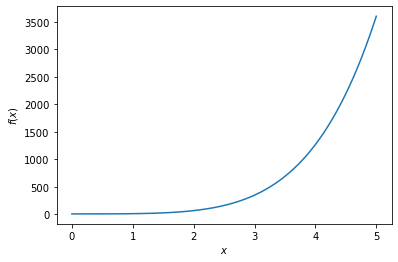

In [6]:
xs = np.linspace(a, b, 1000)
ys = f(xs)
fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
plt.show()

From this, we can see that the area under the curve might be approximately $3000$ (in fact, the exact value is $3212.5$). Let's see how well we can approximate it.

We'll start by creating an array `xs` which contains the edges of the trapeziums (including $a$ and $b$). This should consist of $n+1$ evenly spaced points.

In [7]:
# Create an array of trapezium edges
#part = np.array([(b-a)*i/N for i in range(0,N+1)])

part = np.linspace(0,5,N+1)

From this, calculate the corresponding values of $f(x)$ and store the result in `ys`.

In [8]:
# Compute f at each x

#ys = np.array([f(i) for i in part])

f_map = np.vectorize(f)

ys = f_map(part)


Use the formula above to approximate the area under the curve.

In [9]:
# Calculate the total area of the trapezia
area = ((b-a)/(2*N))*(2*sum(ys) - ys[0] - ys[-1])
print(area)

3212.5000000070927


Perfect. We have the exact solution to a large number of decimal places.

To showcase the speed of NumPy, let's rewrite the code so we can time how long it talks to evaluate. Take the three lines and preface them with `start = time.time()` and follow it with `end = time.time()`. Use these to print out how long the code took to run.

In [13]:
# Time your NumPy solution
start = time.time()

area = ((b-a)/(2*N))*(2*sum(ys) - ys[0] - ys[-1])

end = time.time()
print("Code ran in", round(end - start, 3), "seconds")

Code ran in 0.101 seconds


Below is an implementation written in base Python. Run this to compare the speed with the NumPy version.

In [16]:
start = time.time()
w = (b - a) /N  # width
xs = [a + i * w for i in range(N + 1)]
ys = [f(x) for x in xs]
area = w / 2 * (ys[0] + 2 * sum(ys[1:-1]) + ys[-1])
end = time.time()
print("Code ran in", round(end - start, 3), "seconds")

Code ran in 0.496 seconds


The code is almost identical yet multiple times slower. In fact, NumPy becomes even faster when matrix-type operations are considered.

## Image Processing

For the second project, we will look at how we can use NumPy to perform basic processing with image data. Before we get into this, is it worth understanding how an image is represented by a computer.

To start, images are not stored with infinite resolution. If you were to zoom into an image, you would eventually find that it is made of an incredible small grid, the cells of which are known as pixel (**pic**ture **el**ements).

Each pixel has a value representing its brightness. This often between 0 and 1, or 0 and 255 depending on the scenario. In either case, 0 is black and the highest value is white.

Suppose we have an image with width $w$ and height $h$ (in pixels). We could represent this as an $h \times w$ array.

This, however, will only work for grayscale images. For colour images we will have to introduce _channels_.

It turns out that (in most cases) our eyes only have three types of cones, each responding better to a different wavelength, loosely corresponding to red, green, and blue. For that reason, to represent a colour image, we can get away with just expressing how much of these colours there are in each pixel. We therefore end up with an $h \times w \times 3$ array as shown below.

![RGB Array](images/rgb_array.png)

We can load an image into Python using the Pillow library, before converting it into a NumPy array.

In [17]:
img = np.asarray(Image.open('red_panda.jpg'))

From here we can start to process the image using NumPy.

First, what is the dimensions of our image in pixels? Is it grayscale or colour? Print the array dimensions to find out.

In [18]:
# Image array dimensions
print(img.shape)

(800, 1200, 3)


What is the maximum value of the array?

In [19]:
# Maximum value of array
print(img.max())

255


As mentioned in the last session, we plot heatmaps and images in the same way, using `ax.imshow`. Use this to display the image array.

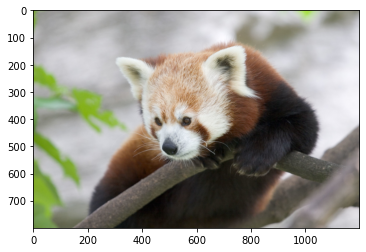

In [20]:
# Display the image
fig, ax = plt.subplots()
ax.imshow(img)

We can (roughly) convert an image to grayscale by averaging over the three colour channels. Do this and plot the result. You will need to set `cmap='gray'` when using `imshow` else matplotlib will use the default viridis colour map.

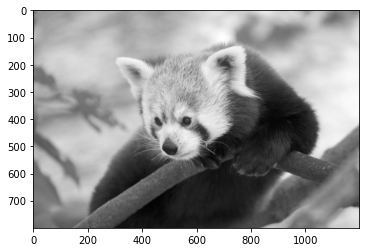

In [24]:
# Convert to grayscale and display
img_gray = np.mean(img, axis = 2 )


fig, ax = plt.subplots()
ax.imshow(img_gray, cmap= 'gray')
plt.show()



> **Technical Note**
>  
>  It turns out that our eyes do not register the same amount of light from the three different channels as having the same luminousity. For that reason, a more accurate conversion to grayscale would use the weighted average $0.299r + 0.587g + 0.114b$.

In a moment, we'll look at how we can denoise an image using SciPy. First we'll need a noisy image. Create `img_noisy` my adding an array of [normal random variables](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) with location parameter zero and scale of $100$ to `img_gray`. Plot the result.

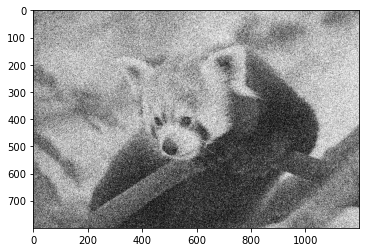

In [26]:
# Add noise and display
img_noisy =  img_gray +  np.random.normal(loc = 0.0 ,scale = 100, size = img_gray.shape )
# Scale and trim the resulting array
img_noisy = np.clip(img_noisy / 255, 0, 1)

fig, ax = plt.subplots()
ax.imshow(img_noisy, cmap='gray')
plt.show()

Although NumPy is useful for performing basic image processing, a more suitable tool is the `scipy.ndimage` module (other useful packages are [OpenCV](https://opencv.org/) and [scikit-image](https://scikit-image.org/)). Here we will give two examples of what it can do, but not go into any detail. You can read more about the module [here](https://docs.scipy.org/doc/scipy/reference/ndimage.html).

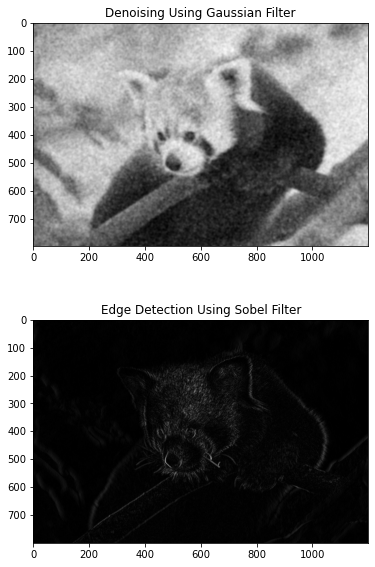

In [27]:
img_clean = ndimage.gaussian_filter(img_noisy, 3)

# Edge detection
sx = ndimage.sobel(img_gray)
sy = ndimage.sobel(img_gray)
img_edge = sob = np.hypot(sx, sy)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))
ax1.imshow(img_clean, cmap='gray')
ax1.set_title("Denoising Using Gaussian Filter")
ax2.imshow(img_edge, cmap='gray')
ax2.set_title("Edge Detection Using Sobel Filter")
plt.show()

## Linear Regression

In the Beginner's Python course we introduced linear regression, a technique for finding the line of best fit between pairs of points $(x_1, y_1), \dots, (x_n, y_n)$. Don't worry if you didn't see this, of course. In this example we will use a different method for finding such a line involving matrices that allows us to generalise to more dimensions.

Before we get started, we need to introduce some basic concepts of linear algebra. First we have the matrix.

A matrix is simply a two dimensional array. Here we create two matrices `A` and `B`.

In [28]:
A = np.array([
    [1, 2],
    [3, 4]
])
B = np.array([
    [5, 6, 7],
    [8, 9, 10]
])

We multiply matrices in a particular way, which you can read about [here](https://www.mathsisfun.com/algebra/matrix-multiplying.html). Thankfully, NumPy has this functionality built in so we don't have to worry about the underlying mechanics.

In [29]:
np.matmul(A, B)

array([[21, 24, 27],
       [47, 54, 61]])

Notice that this is not the same thing as element-wise multiplication using `*`. In fact, element-wise multiplication is invalid here due to the incompatible shapes of the arrays.

The only rule you have to be aware of is that you can only multiply matrices when the number of columns in the first matches the number of rows in the second, else we obtain the following error.

In [30]:
np.matmul(B, A)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

A shorthand for matrix multiplication is the `@` symbol.

In [31]:
A @ B

array([[21, 24, 27],
       [47, 54, 61]])

Matrices also have inverses. Just as how the number $4$ has the inverse $\frac{1}{4}$, (some) matrices also have inverses, denoted by $A^{-1}$. These can be calculated (when they exist) using `np.linalg.inv`. Note that this is not the same as `1 / A`.

In [32]:
A_inv = np.linalg.inv(A)
A_inv

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

Just as how $4 \times \frac{1}{4} = 1$, we have a similar result for matrix inverses.

In [33]:
np.round(A @ A_inv, 5)

array([[1., 0.],
       [0., 1.]])

> **Technical Note**
>
> If we want to calculate $A^{-1}$ for the purpose of solving $Ax = b$, it is much more efficient and numerically stable to use `np.linalg.solve(A, b)`. Read more about this [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

The final matrix operation we need to be aware of is transposition. This involves switching the rows and columns of the matrix, effectively flipping the matrix along its diagonal. The transpose of $A$ is written as $A^T$.

In [34]:
A.T

array([[1, 3],
       [2, 4]])

With this knowledge, we are ready to look at linear regression. To do this, we'll return to our beloved wine dataset from session one, and attempt to predict the quality of a bottle of wine from its other predictors. We start by importing the dataset.

In [129]:
wine = pd.read_csv('winequality-red.csv', sep=';')



We will start by splitting our dataset in a data matrix `X` and 1D array (called a vector) `y` using the method we say in the _Arrays from Dataframes_ section of the teaching course.

In linear regression, we assume that it is reasonable to predict the output (wine quality) by taking a weighted sum of the other predictor variables plus a fixed intercept. Our goal is to estimate the "best" weights (that is how important each feature is in predicting wine quality). 

> **Technical Note**
>
> We define the best set of weights to be those that minimise the average squared error between our predictions and the true value.

Some [fancy maths](http://mezeylab.cb.bscb.cornell.edu/labmembers/documents/supplement%205%20-%20multiple%20regression.pdf) shows that this best set of weights (which we denote $\hat\beta$) is given by the following matrix expression (where all multiplications are matrix multiplications, not element-wise).

$$\hat\beta = \left(X^T \times X \right) \times X^T \times y$$

Each element of $\hat\beta$ tell us the contribution of the corresponding feature. For example, if the value of $\hat\beta$ corresponding to pH was 0.5, it would be been that, on average, an increase in pH of one unit, increases wine quality by 0.5 units.

With that in mind, let's find these weights.

Start by creating a matrix `X` containing all columns of `wine` except `quality` as a NumPy array.

In [131]:
# Create our data matrix, X
X = wine.drop(['quality'], axis = 1)

X


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


We'll also need to convert the column `quality` into a NumPy array.

In [124]:
# Create a vector of responses, y
y =np.array(wine['quality'])



If we were to continue with our current $X$, we would be forcing our model to predict a wine quality of zero when all the predictors are zero. This is likely an unreasonable assumption. To get around this, we add a new column to the start of `X` which contains only ones. We can create such a column using `np.ones(shape=(X.shape[0], 1))` and then concatenate this with the current `X`.

In [138]:
# Add a column of ones to the start of X
ones = np.ones(shape=(X.shape[0], 1))

X = np.concatenate((ones, X), axis = 1)

X


array([[ 1.   ,  7.4  ,  0.7  , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 1.   ,  7.8  ,  0.88 , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 1.   ,  7.8  ,  0.76 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 1.   ,  6.3  ,  0.51 , ...,  3.42 ,  0.75 , 11.   ],
       [ 1.   ,  5.9  ,  0.645, ...,  3.57 ,  0.71 , 10.2  ],
       [ 1.   ,  6.   ,  0.31 , ...,  3.39 ,  0.66 , 11.   ]])

From here, we can calculate `beta_hat` using the formula above.

In [144]:
# Compute the optimum weights

inverse_part = np.linalg.inv(X.T @ X)

beta_hat = inverse_part @  X.T @ y

beta_hat


array([ 2.19652084e+01,  2.49905526e-02, -1.08359026e+00, -1.82563948e-01,
        1.63312697e-02, -1.87422516e+00,  4.36133331e-03, -3.26457970e-03,
       -1.78811638e+01, -4.13653144e-01,  9.16334413e-01,  2.76197699e-01])

> **Bonus**
>
> Can you rewrite this in a numerically-stable way using the tip above?

Run the following code to plot the estimated feature weights.

<BarContainer object of 11 artists>

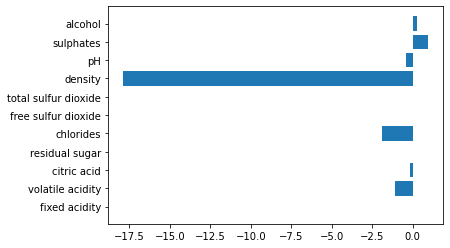

In [146]:


# Plot feature weights
fig, ax = plt.subplots()
ax.barh(wine.columns[:-1], beta_hat[1:])

Note, this doesn't represent how important the features are in predicting quality (since the variables are on different scales) though it is related. Rather it tells us how we would predict the quality for a new wine.

For example, suppose we are given a bottle with the following attributes.

In [147]:
wine_new = pd.DataFrame({
    'fixed acidity': 7.1, 'volatile acidity': 0.6,
    'citric acid': 0.0, 'residual sugar': 1.7,
    'chlorides': 0.072, 'free sulfur dioxide': 12,
    'total sulfur dioxide': 41, 'density': 0.996,
    'pH': 3.4, 'sulphates': 0.61, 'alcohol': 9.5
}, index=[0])

wine_new

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.1,0.6,0.0,1.7,0.072,12,41,0.996,3.4,0.61,9.5


We can predict the quality of this wine by converting it to a matrix `X_new`, concatenating a single 1 one the start, and calculating `X_new @ beta_hat`. What is the prediction?

In [150]:
# Predict the quality for the new wine data
X_new = np.array(wine_new)

X_new = np.insert(X_new, 0 , 1)

beta_hat 

X_new @ beta_hat

5.27057666579158

In reality, we wouldn't compute linear regression in this way, as scikit-learn (which we'll learn about in session five), has it all implemented for us. It is nice however to be able to work at a low-level in case we want to create novel models and algorithms.

> **Limitations of Regression**
>
> Linear regression is an incredible simple model that is likely not going to capture the true relationship between the predictors and response. We will see more powerful models in session five. It is, however, highly interpretable which can be beneficial in a business setting.